# Prepare the Notebook

In [0]:
!pip install control
!git clone https://magiccvs.byu.edu/gitlab/control_book/control_book_public_solutions.git
#!cd control_book_public_solutions/;  git checkout Fall19_edits

     |████████████████████████████████| 256kB 2.9MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=ff44229c7f757870e665a24c8055460324a19fb40b81d608deb8bf217e1e733b
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control
Cloning into 'control_book_public_solutions'...
remote: Enumerating objects: 2414, done.
remote: Counting objects: 100% (2414/2414), done.
remote: Compressing objects: 100% (1211/1211), done.
remote: Total 2414 (delta 1242), reused 2268 (delta 1145), pack-reused 0
Receiving objects: 100% (2414/2414), 42.77 MiB | 17.62 MiB/s, done.
Resolving deltas: 100% (1242/1242), done.


In [0]:
!cd control_book_public_solutions/;  git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://magiccvs.byu.edu/gitlab/control_book/control_book_public_solutions
   1b4e246..b619086  master     -> origin/master
Updating 1b4e246..b619086
Fast-forward
 _a_arm/python/hw14/armParamHW14.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [0]:
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

In [0]:
# Insert figures:
basename = 'control_book_public_solutions/_images/'  #Use this for operating in Colab
#basename = './'                                     #Use this for operating out of a Jupyter server on your machine
img1 = Image(filename=basename+'figures_4/ss_input_disturbance.png',width=700)
#img2 = Image(filename=basename+'figures_4/ss_observer_based_feedback_w_integrator.png',width=700)

In [0]:
def plotStepResults(Y, T, X, n):
    # Plot the results out of a control toolbox 'step'
    # Inputs:
    # Y - Output of the step command
    # T - Time array
    # X - states from the system during the step simulation
    # n - number of states
    ### Din - disturbance

    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

    axs[0].plot(T, X[:, 0], T, X[:, 0 + n])
    axs[0].set_title('Position: Truth vs. Estimates')
    axs[0].set_xlabel('t (s)')
    axs[0].set_ylabel('Position (m)')
    axs[0].legend(('True', 'Est'))

    axs[1].plot(T, X[:, 1], T, X[:, 1 + n])
    axs[1].set_title('Velocity: Truth vs. Estimates')
    axs[1].set_xlabel('t (s)')
    axs[1].set_ylabel('Velocity (m/s)')
    axs[1].legend(('True', 'Est'))

    axs[2].plot(T, X[:, 2], T, X[:, 2 + n])
    axs[2].set_title('Acceleration: Truth vs. Estimates')
    axs[2].set_xlabel('t (s)')
    axs[2].set_ylabel('Accel (m/s^2)')
    axs[2].legend(('True', 'Est'))

    #axs[3].plot(T, X[:, -1])
    #axs[3].set_title('Integrator Statetes')
    #axs[3].set_xlabel('t (s)')
    #axs[3].set_ylabel('Angle (r)')
    #axs[3].legend(('True', 'Est'))

    #axs[4].plot(T, Din * np.ones_like(T), T, X[:, -1])
    #axs[4].set_title('Input Disturbance: Truth vs. Estimates')
    #axs[4].set_xlabel('t (s)')
    #axs[4].set_ylabel('Input Disturbance (N)')
    #axs[4].legend(('True', 'Est'))

    fig.tight_layout()

    plt.show()

# Part 4: Observer-based Control Design
## Chapter 14: Disturbance Observer Design

### Lecture Notes

This notebook covers the material in Chapter 14 of the [text](http://controlbook.byu.edu/doku.php) in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical.

### 14.1 Theory
In previous chapters we have discussed that modeling errors and other real-world effects result in an input disturbance\index{input disturbance} to the system as shown below: 

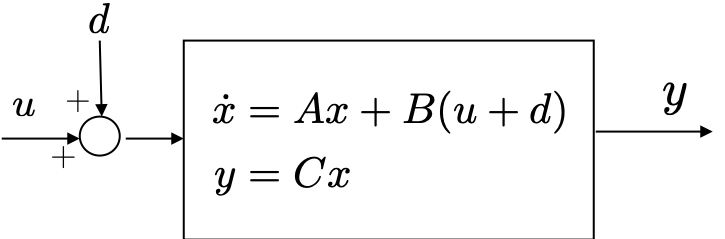

In [0]:
img1

The objective of this chapter is to explain the effect of the disturbance on an observer.  It turns out that the disturbance creates a steady state bias in the observer states.  We will also describe how the observer can be augmented, the dual of adding an integrator, to estimate the disturbance and to remove the steady state observation error. 

## 14.2 Summary of the Design Process - Estimator Design with Disturbance
Since the chapter content up to this point is fairly analytical, we have skipped adding it here and instead, we present a new example along with some of the Design Study examples. 

The procedure for designing an observer is summarized as follows.

Given the plant with augmented disturbance state

$\dot{x_d} = A_2 x_d + B_2 u$

$y = C_2 x_d$, 

where now $x_d = \begin{pmatrix} x & d \end{pmatrix}$ and 

$A_2 = \begin{pmatrix} A & B \\ \mathbf{0} & 0 \end{pmatrix} $

$B_2 = \begin{pmatrix} B \\ 0 \end{pmatrix} $

$C_2 = \begin{pmatrix} C & 0 \end{pmatrix}.$

find the observer gain $L$ so that the state observer

$\dot{\hat{x}_d}=A_2\hat{x}_d + B_2 u + L(y-C_2\hat{x}_d)$

has stable estimation error dynamics with poles located at $q_1, q_2, \dots, q_n, q_d$.


> (1)  Check to see if the system is observable by computing the observability matrix

$\mathcal{O}_{A,C} = \begin{pmatrix} C_2 \\ C_2 A_2 \\ C_2 A_2^2 \\ \vdots \\ C_2 A_2^{n-1}\end{pmatrix}$

and checking to see if $\text{rank}(\mathcal{O}_{A,C})=n$.

> (2) Find the open-loop characteristic polynomial

$\Delta_{ol}(s)=\text{det}(sI-A) = s^n + a_{n-1}s^{n-1} + \cdots + a_1 s + a_0,$

and construct the row vector

$\mathbf{a}_A = \begin{pmatrix} a_{n-1}, & a_{n-2}, & \dots, & a_1, & a_0\end{pmatrix}$

and the matrix

$\mathcal{A}_A = \begin{pmatrix} 
1 & a_{n-1} & a_{n-2} & \cdots & a_2 & a_1 \\
0 & 1       & a_{n-1} & \cdots & a_3 & a_2 \\
\vdots & & \ddots &  &  & \vdots \\
0 & 0 & \cdots & 0 & 1 & a_{n-1} \\
0 & 0 & \cdots & 0 & 0 & 1 
\end{pmatrix}
$

> (3) Find the desired characteristic polynomial for the observation error

$\Delta_{obs}^d(s) = (s-q_1)(s-q_2)\cdots(s-q_n) = s^n + \beta_{n-1}s^{n-1} + \cdots + \beta_1 s + \beta_0,$

and construct the row vector

$\boldsymbol{\beta} = \begin{pmatrix}\beta_{n-1}, & \beta_{n-2}, & \dots, & \beta_1, & \beta_0 \end{pmatrix}.$

> (4) Compute the desired observer gains as

$L = \mathcal{O}_{A,C}^{-1}(\mathcal{A}_A^\top)^{-1}(\boldsymbol{\beta}-\mathbf{a}_A)^\top$


### Example System
The following is a quick example that is not in the book.  This first portion is the same as the previous chaper. The new developments are in the next cell

In [0]:
# System Model
A = np.array([[0.,1.,0.],[0.,0.,1.],[-1.,-5.,-6.]])
B = np.array([[0.],[0.],[1.]])
C = np.array([1., 0., 0.])
C = np.reshape(C,(1,3))
n = A.shape[0]

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((A.shape[0],1))),1)
Ai2 = np.concatenate((-C,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

# Desired poles (+1 for the integrator pole): 
tr = 1.
zeta = 0.707
wn = 2.2/tr  # natural frequency for position
des_char_poly = np.convolve([1., 2.*zeta*wn, wn**2.],
                            [1., 25., 150.])
dpoles = np.roots(des_char_poly)
#print('Poles: ',dpoles)

# Step 1: Check controllability: 
Ctrl = ctrb(Ai,Bi)
r = np.linalg.matrix_rank(Ctrl)
print('Rank of Controllability Matrix: ', r)
if r != 4:
    print("The system is not controllable!!")
else:
    # Step 2: Compute the gains: 
    Kp = acker(Ai, Bi, dpoles)
    K = Kp[0,0:3]
    Ki = Kp[0,-1]
    # Step 3: Compute k_r (for comparision only, below)
    kr = -1.0/(C*np.linalg.inv(A-B@K)@B)
Ki = Ki*np.ones((1,1))
print('K: ', K)
print('Ki:', Ki)
print('kr: ', kr)

# Estimator Design - No disturbance
depoles = dpoles[0:n]*4.

Obsv = ctrb(A.T,C.T)

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(Obsv) != n:
    print("The system is not observerable")
else:
    L = acker(A.T, C.T, depoles).T

print('L: ', L)

Rank of Controllability Matrix:  4
K:  [[586.62   227.61    22.1108]]
Ki: [[-726.]]
kr:  [[587.62]]
L:  [[ 100.2216]
 [2415.8304]
 [ -65.2504]]


### Disturbance Estimator Design
Add in an estimate for the constant disturbance.  

In [0]:
Ad1 = np.concatenate((A, B),1) # Append state space with disturbance terms
Ad2 = np.concatenate((np.zeros((1,n)), np.zeros((1,1))),1 ) 
Ad = np.concatenate((Ad1,Ad2))
Cd = np.concatenate((C, np.zeros((1,1))),1)

# Use the integrator poles for the disturbance observer: 
depoles_d = dpoles*4.

# Construct the Observability matrix: 
Obsvd = ctrb(Ad.T,Cd.T)

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(Obsvd) != n+1:
    print("The system is not observerable")
else:
    Ld = acker(Ad.T, Cd.T, depoles_d).T

print('Observer Gains: ', Ld)
L2 = Ld[0:n,0]
Ld = Ld[-1,0]

Observer Gains:  [[1.06443200e+02]
 [3.07810080e+03]
 [1.86058592e+04]
 [1.85856000e+05]]


### Simulate the system
Simulate with the estimates in the feedback loop for both the regular estimator and the estimator with a disburbance observer. I've added a disturbance and some modeling errors, to stimulate the estimator. 

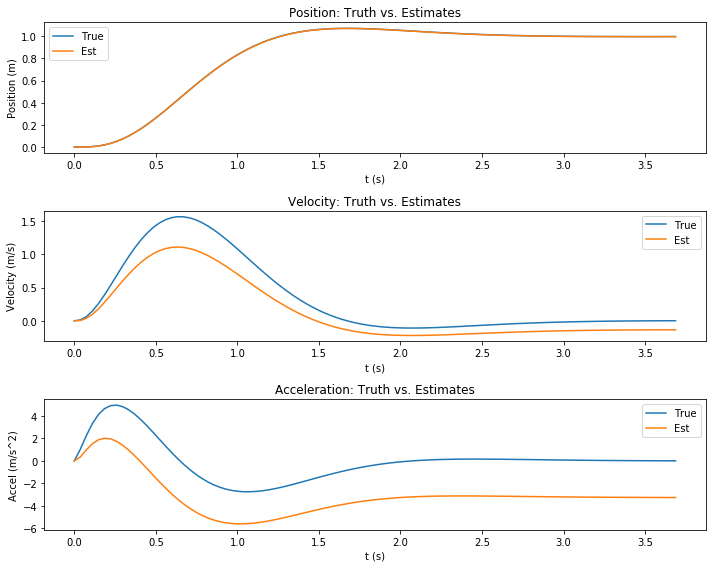

In [0]:
Din = 20. # Input disturbance
Aerr = 0.8 # multiplcation factor for modeling errors in A 

# System with regular estimator (Ch 13 stuff), estimates in the loop
Aec1 = np.concatenate((Aerr*A, -B@K, -B@Ki), 1)  # True state dyanmics (notice the change in the feedback)
Aec2 = np.concatenate((L@C, A-B@K-L@C, -B@Ki), 1)      # Estimator dynamics
Aec3 = np.concatenate((-C, np.zeros((1,n)), np.zeros((1,1))), 1) # Integrator dyanmics
Aec = np.concatenate((Aec1,Aec2,Aec3))
Bec = np.concatenate((B*Din, np.zeros((n, 1)), np.ones((1, 1))))
Cec = np.concatenate((C, np.zeros((1, n)), np.zeros((1, 1))), 1)
Dec = np.zeros((1,1))

# System with disturbance estimator added (Ch 14 stuff), estimates in loop
Aed1 = np.concatenate((Aerr*A, -B@K, -B@Ki, np.zeros((n,1))), 1)      # True state dyanmics (notice the change in the feedback)
Aed2 = np.concatenate((L2@C, A-B@K-L2@C, -B@Ki, B), 1)                # Estimator dynamics
Aed3 = np.concatenate((-C, np.zeros((1,n)), np.zeros((1,1)), np.zeros((1,1))), 1) # Integrator dyanmics
Aed4 = np.concatenate((Ld*C, -Ld*C, np.zeros((1,1)), np.zeros((1,1))), 1)  # Disturbance input dyanmics
Aed = np.concatenate((Aed1,Aed2,Aed3,Aed4))
Bed = np.concatenate((B*Din, np.zeros((n, 1)), np.ones((1, 1)), np.zeros((1,1)))) # disturbance only acts on true state, but we estimate it 
Ced = np.concatenate((C, np.zeros((1, n)), np.zeros((1, 1)), np.zeros((1, 1))), 1)
Ded = np.zeros((1,1))

sys_ce = ss(Aec, Bec, Cec, Dec)
sys_ed = ss(Aed, Bed, Ced, Ded)

y,t,x = step(sys_ce, return_x=True)
y2,t2,x2 = step(sys_ed, return_x=True)

# Plot results for the estimates in the loop, not estimating disturbance: 
plotStepResults(y, t, x, n)

See the discrepancies in the truth and estimates caused by a modeling discrepancy and an input disturbance. 
The integral control is aiding our estimation, helping to converge to the truth for the position state (because we are feeding truth back, instead of sensors)

### Estimates with Disturbance Estimator - Estimates in the Control Loop

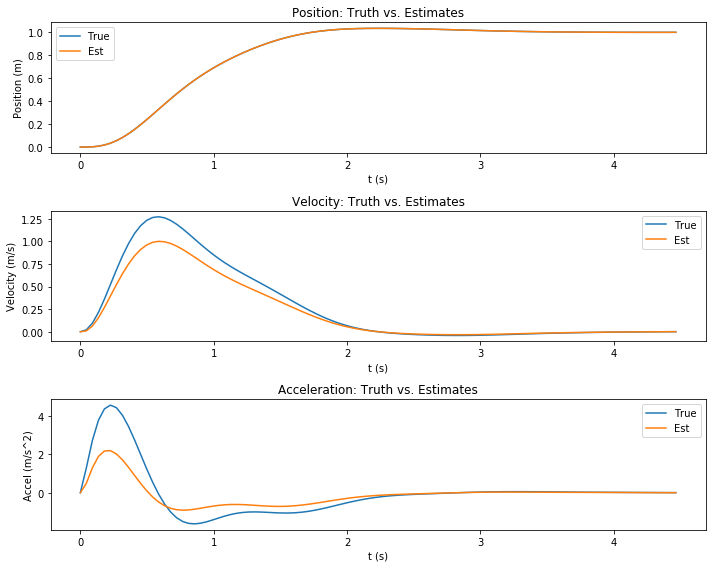

In [0]:
plotStepResults(y2, t2, x2, n)

Note how the disturbance goes down to zero as our observer gets improved estimates of the disturbance.  This also allows the performance of our system to improve slightly (small rise time change in the position plot compared to the figure above). 

# Examples: Design Study A. Single Link Robot Arm

> (a) Modify the simulation from HW13 so that the uncertainty parameter in arm\_dynamics.m is $\alpha=0.2$, representing 20\% inaccuracy in the knowledge of the system parameters and so that the input disturbance is $0.5$~Newton-meters. Also, add noise to the output channel $\theta_m$ with a standard deviation of $0.001$.  Before adding the disturbance observer, run the simulation and note that the controller is not robust enough to handle the large input disturbance.

> (b) Add a disturbance observer to the controller, and verify that the steady state error in the estimator has been removed.  Tune the system to get good response.

## A - Modify the Simulation
We will use the short cut method from the example above to quickly simulate our system, before running the full nonlinear simulation.  



In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
#sys.path.append('control_book_public_solutions/_a_arm/python/hw1/')  # add homework directory
import armParam as P
import hw10.armParamHW10 as PP

# Desired poles: 
des_char_poly = np.array([1., 2.*PP.zeta*PP.wn, PP.wn**2.])
dpoles = np.roots(des_char_poly)
#Augment the desired poles: 
dpoles = np.concatenate((dpoles,np.array([-9.])))
print("Desired pole locations: ", dpoles)

Desired pole locations:  [-3.8885+3.8896745j -3.8885-3.8896745j -9.    +0.j       ]


In [0]:
# System Model
# State Space Equations
# xdot = A*x + B*u
# y = C*x
A = np.array([[0.0, 1.0],
               [0.0, -1.0*P.b/P.m/(P.ell**2)]])
n = A.shape[0]
B = np.array([[0.0],
               [3.0/P.m/(P.ell**2)]])
C = np.array([[1.0, 0.0]])

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((A.shape[0],1))),1)
Ai2 = np.concatenate((-C,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

In [0]:
Cntl = ctrb(Ai,Bi)
r = np.linalg.matrix_rank(Cntl)
print('Rank of Controllability Matrix: ', r, ', which should equal: ', n+1)

Rank of Controllability Matrix:  3 , which should equal:  3


In [0]:
Kp = acker(Ai, Bi, dpoles)
K = Kp[0,0:n]
Ki = Kp[0,-1]
Ki = np.reshape(Ki,(1,1))
kr = -1.0/(C*np.linalg.inv(A-B@K)@B)

print("Feedback gain K: ", K)
print("Integrator gain Ki: ", Ki)
print("Reference gain k_r: ", kr)

Feedback gain K:  [[1.503645   0.23498833]]
Integrator gain Ki:  [[-4.08375]]
Reference gain k_r:  [[1.503645]]


L:  [[ 14.44288889]
 [104.95234568]]


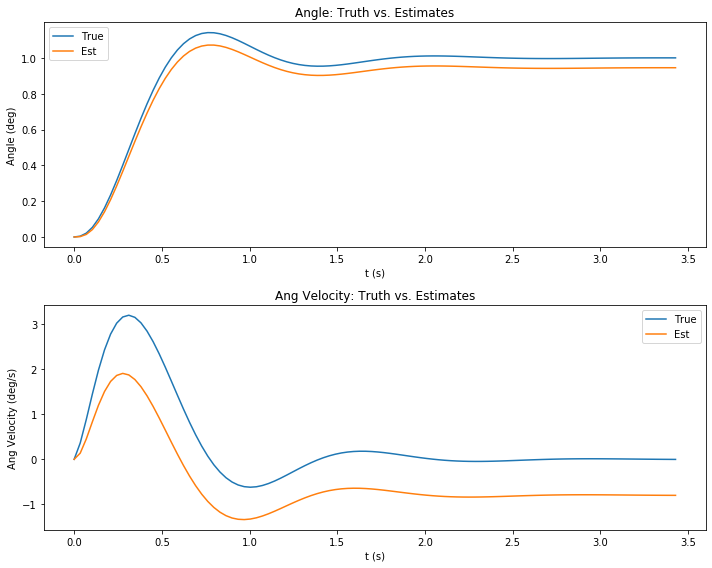

In [0]:
# Add the Estimator: 
depoles = dpoles[0:n]*2.

Obsv = ctrb(A.T,C.T)

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(Obsv) != n:
    print("The system is not observerable")
else:
    L = acker(A.T, C.T, depoles).T

print('L: ', L)

# Simulate the estimates in the control loop: 
Din = 0.1 
Aerr = 0.8 

Aec1 = np.concatenate((Aerr*A, -B@K, -B@Ki), 1)  # True state dyanmics (notice the change in the feedback)
Aec2 = np.concatenate((L@C, A-B@K-L@C, -B@Ki), 1)      # Estimator dynamics
Aec3 = np.concatenate((-C, np.zeros((1,n)), np.zeros((1,1))), 1) # Integrator dyanmics
Aec = np.concatenate((Aec1,Aec2,Aec3))
Bec = np.concatenate((B*Din, np.zeros((n, 1)), np.ones((1, 1))))
Cec = np.concatenate((C, np.zeros((1, n)), np.zeros((1, 1))), 1)
Dec = np.zeros((1,1))

sys_ce = ss(Aec, Bec, Cec, Dec)

y,t,x = step(sys_ce, return_x=True)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axs[0].plot(t, (x[:, 0]), t, (x[:, 0 + n]))
axs[0].set_title('Angle: Truth vs. Estimates')
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Angle (deg)')
axs[0].legend(('True', 'Est'))

axs[1].plot(t, (x[:, 1]), t,  (x[:, 1 + n]))
axs[1].set_title('Ang Velocity: Truth vs. Estimates')
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('Ang Velocity (deg/s)')
axs[1].legend(('True', 'Est'))

fig.tight_layout()


### Implement Disturbance Observer: 

Desired Observer pole locations:  [-3.8885+3.8896745j -3.8885-3.8896745j -9.    +0.j       ]


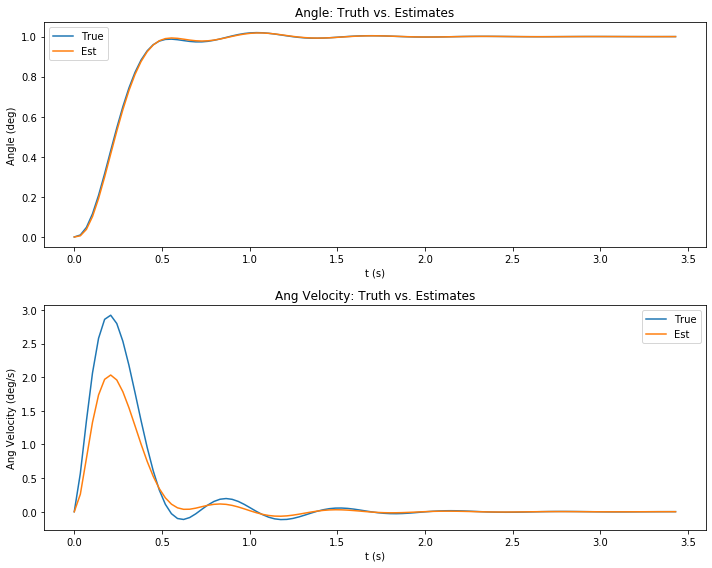

In [0]:
wn_obs = 10
zeta = 0.707
dist_obsv_pole = -5.5         # pole for disturbance observer

A2 = np.concatenate((
        np.concatenate((A, B), axis=1),
        np.zeros((1, 3))),
        axis=0)
B2 = np.concatenate((B, np.zeros((1, 1))), axis=0)
C2 = np.concatenate((C, np.zeros((1, 1))), axis=1)

des_char_est = np.array([1., 2.*zeta*wn_obs, wn_obs**2.])
des_poles_est = np.roots(des_char_est)
des_obsv_poles = np.concatenate((des_poles_est,dist_obsv_pole*np.ones(1)))
print("Desired Observer pole locations: ", dpoles)

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(ctrb(A2.T, C2.T)) != 3:
    print("The system is not observerable")
else:
    Ldist = acker(A2.T, C2.T, des_obsv_poles).T
    L2 = np.array([[Ldist.item(0)], [Ldist.item(1)]])
    Ld = L2.item(0)


# System with disturbance estimator added (Ch 14 stuff), estimates in loop
Aed1 = np.concatenate((Aerr*A, -B@K, -B@Ki, np.zeros((n,1))), 1)      # True state dyanmics (notice the change in the feedback)
Aed2 = np.concatenate((L2@C, A-B@K-L2@C, -B@Ki, B), 1)                # Estimator dynamics
Aed3 = np.concatenate((-C, np.zeros((1,n)), np.zeros((1,1)), np.zeros((1,1))), 1) # Integrator dyanmics
Aed4 = np.concatenate((Ld*C, -Ld*C, np.zeros((1,1)), np.zeros((1,1))), 1)  # Disturbance input dyanmics
Aed = np.concatenate((Aed1,Aed2,Aed3,Aed4))
Bed = np.concatenate((B*Din, np.zeros((n, 1)), np.ones((1, 1)), np.zeros((1,1)))) # disturbance only acts on true state, but we estimate it 
Ced = np.concatenate((C, np.zeros((1, n)), np.zeros((1, 1)), np.zeros((1, 1))), 1)
Ded = np.zeros((1,1))

sys_ed = ss(Aed, Bed, Ced, Ded)

y2,t2,x2 = step(sys_ed, return_x=True)

# Plot results for the estimates in the loop, not estimating disturbance: 
#plotStepResults(y2, t2, x2, n)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axs[0].plot(t, (x2[:, 0]), t, (x2[:, 0 + n]))
axs[0].set_title('Angle: Truth vs. Estimates')
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Angle (deg)')
axs[0].legend(('True', 'Est'))

axs[1].plot(t, (x2[:, 1]), t,  (x2[:, 1 + n]))
axs[1].set_title('Ang Velocity: Truth vs. Estimates')
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('Ang Velocity (deg/s)')
axs[1].legend(('True', 'Est'))

fig.tight_layout()

Note the improved performance of the system when we are observing and removing the disturbance.  Overshoot decreases, speed of response slightly increases, and the bias in the angular velocity estimate goes to zero. The disturbance does still affect the system, but not nearly as drastically. 

## A - (b) Implement Control & Disturbance Estimator and Simulate 

In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw14/')  # add homework directory
import armParam as P
from hw3.armDynamics import armDynamics
from hw14.armController import armController
from hw2.signalGenerator import signalGenerator
from hw2.armAnimation import armAnimation
from hw2.dataPlotter import dataPlotter as armPlotData
from hw13.dataPlotterObserver import dataPlotterObserver

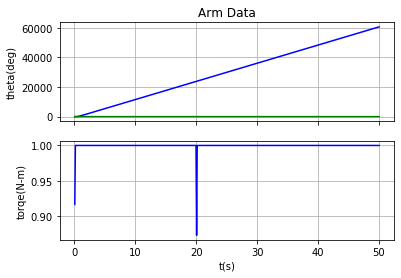

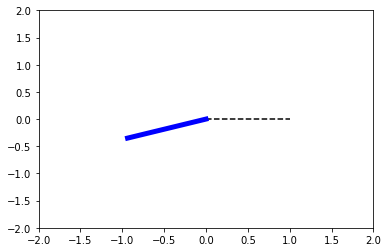

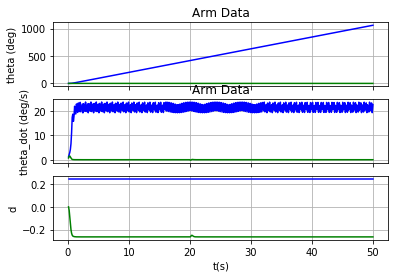

In [0]:
# instantiate arm, controller, and reference classes
arm = armDynamics(0.1)
ctrl = armController()
disturbance = signalGenerator(amplitude=0.25)
noise = signalGenerator(amplitude=0.01)
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

# instantiate the simulation plots and animation
armDataPlot = armPlotData()
animation = armAnimation() #doesn't work through Colab, but works with regular Jupyter (uncomment the %matplotlib tk)
dataPlotObserver = dataPlotterObserver()

t = P.t_start  # time starts at t_start
y = arm.h()
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    ref_input = np.reshape(ref_input, (1,1))
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        d = disturbance.step(t)  # input disturbance np.zeros((1,1))  #
        n = np.zeros((1,1))  #noise.random(t)  # simulate sensor noise
        u, xhat, dhat = ctrl.update(ref_input, y) # + n  # Calculate the control value
        sys_input = u + d
        arm.update(sys_input)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(arm.state)
    armDataPlot.update(t, ref_input, arm.state, u)
    dataPlotObserver.update(t, arm.state, xhat, d, dhat)
    #plt.pause(0.00001)  # the pause causes the figure to be displayed during the simulation - uncomment for Jupyter

So this is obviously NOT working well here.  It so happens that if we run the exact same code via command line, the results work out perfectly.  So there are some issues running the simulation in Colab that need to be worked out.... 


In [0]:
def postProcessPlot(dataPlot_arm):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=2, ncols=1)
  fig.tight_layout()
  plt.subplot(211)  
  plt.plot(dataPlot_arm.time_history, np.transpose([dataPlot_arm.theta_history, dataPlot_arm.theta_ref_history]))
  plt.title('Arm Data' )
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(212)
  plt.plot(dataPlot_arm.time_history, dataPlot_arm.torque_history)
  plt.ylabel('Torque (N-m)')
  plt.xlabel('time (s)')

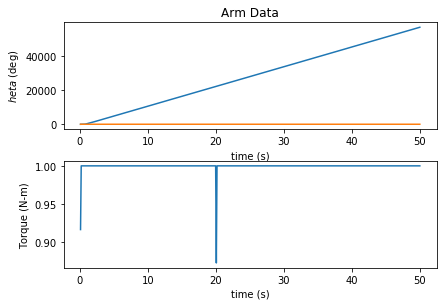

In [0]:
postProcessPlot(armDataPlot)

# Examples - Design Study B: Inverted Pendulum
> (a) Modify the simulation from HW13 so that the uncertainty parameter in pendulum\_dynamics.m is $\alpha=0.2$, representing 20\% inaccuracy in the knowledge of the system parameters, and so that the input disturbance is $0.5$. Also, add noise to the output channels $z_m$ and $\theta_m$ with a standard deviation of $0.001$.  Before adding the disturbance observer, run the simulation and note that the controller is not robust to the large input disturbance.

> (b) Add a disturbance observer to the controller, and verify that the steady state error in the estimator has been removed.  Tune the system to get good response.


# TODO: Revise the content below this line!

In [0]:
%reset -f
# Design Problem B : Pendulum
# Start fresh, global namespace is clear: 
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_B_pendulum/python')
sys.path.append('control_book_public_solutions/_B_pendulum/python/hw13/')  # add homework directory
import pendulumParam as P
import hw10.pendulumParamHW10 as PP

DC_gain 1.8754253767622748
kp_th:  -26.24319727891157
kd_th:  -3.1478333333333333
kp_z:  -0.06189092517559949
ki_z:  -0.005
kd_z:  -0.1506408552390715


## B - Demonstrate Methods 
Before running the simulation, demonstrate and test out the estimator design.  The first cell below is work from the previous chapter.  The next code cell contains the estimator designs for this chapter. 



In [0]:
# gain calculation
wn_th = 2.2/PP.tr_th  # natural frequency for angle
wn_z = 2.2/PP.tr_z  # natural frequency for position
des_char_poly = np.convolve([1, 2*PP.zeta_z*wn_z, wn_z**2],
                            [1, 2*PP.zeta_th*wn_th, wn_th**2])
des_poles = np.roots(des_char_poly)
# Add pole for the integrator: 
des_poles = np.concatenate((des_poles,np.array([-10.])))

A = np.array([[0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 1.0],
               [0.0, -3*P.m1*P.g/4/(.25*P.m1+P.m2),
                -P.b/(.25*P.m1+P.m2), 0.0],
               [0.0, 3*(P.m1+P.m2)*P.g/2/(.25*P.m1+P.m2)/P.ell,
                3*P.b/2/(.25*P.m1+P.m2)/P.ell, 0.0]])
B = np.array([[0.0],
               [0.0],
               [1/(.25*P.m1+P.m2)],
               [-3.0/2/(.25*P.m1+P.m2)/P.ell]])

C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])
Cr = np.array([[1.0, 0.0, 0.0, 0.0]])

n = A.shape[0]

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((n,1))),1)
Ai2 = np.concatenate((-Cr,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(ctrb(Ai, Bi)) != n+1:
    print("The system is not controllable")
else:
    Kp = acker(Ai, Bi, des_poles)
    K = Kp[0,0:n]
    Ki = Kp[0,-1]
    kr = -1.0/(Cr*np.linalg.inv(A-B@K)@B)

Ki = np.reshape(Ki, (1,1))
print('K: ', K)
print('Ki: ', Ki)
print('kr: (for comparison) ', kr)

K:  [[-14.52422775 -68.64849944 -18.91434983 -13.29239994]]
Ki:  [[5.64157225]]
kr: (for comparison)  [[-14.52422775]]


### Estimator Design

In [0]:
# Add the Estimator: 
depoles = des_poles[0:n]*6.

Obsv = ctrb(A.T,C.T)

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(Obsv) != n:
    print("The system is not observerable")
else:
    L = acker(A.T, Cr.T, depoles).T

print('L: ', L)

L:  [[    58.61374118]
 [ -5997.67519737]
 [  1752.8085204 ]
 [-46801.42561313]]


SImulate the Estimator - using simple step function

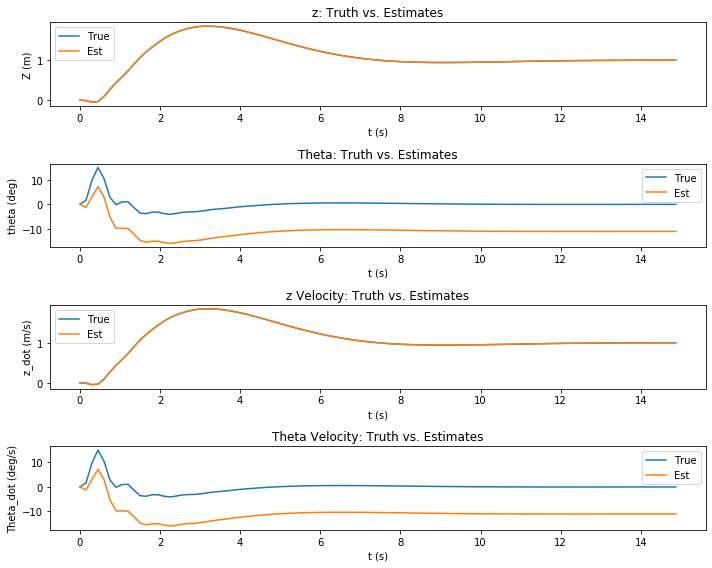

In [0]:
# Modeling errors and disturbance input: 
Aerr = 0.99
Din = 0.1 

# Simulate the estimates in the control loop:
Aec1 = np.concatenate((Aerr*A, -B@K, -B@Ki), 1)  # True state dyanmics (notice the change in the feedback)
Aec2 = np.concatenate((L@Cr, A-B@K-L@Cr, -B@Ki), 1)      # Estimator dynamics
Aec3 = np.concatenate((-Cr, np.zeros((1,n)), np.zeros((1,1))), 1) # Integrator dyanmics
Aec = np.concatenate((Aec1,Aec2,Aec3))
Bec = np.concatenate((B*Din, np.zeros((n, 1)), np.ones((1, 1))))
Cec = np.concatenate((Cr, np.zeros((1, n)), np.zeros((1, 1))), 1)
Dec = np.zeros((1,1))

sys_ce = ss(Aec, Bec, Cec, Dec)

y,t,x = step(sys_ce, return_x=True)

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

axs[0].plot(t, (x[:, 0]), t, (x[:, 0 + n]))
axs[0].set_title('z: Truth vs. Estimates')
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Z (m)')
axs[0].legend(('True', 'Est'))

axs[1].plot(t, np.rad2deg(x[:, 1]), t,  np.rad2deg(x[:, 1 + n]))
axs[1].set_title('Theta: Truth vs. Estimates')
axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('theta (deg)')
axs[1].legend(('True', 'Est'))

axs[2].plot(t, (x[:, 0]), t, (x[:, 0 + n]))
axs[2].set_title('z Velocity: Truth vs. Estimates')
axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('z_dot (m/s)')
axs[2].legend(('True', 'Est'))

axs[3].plot(t, np.rad2deg(x[:, 1]), t,  np.rad2deg(x[:, 1 + n]))
axs[3].set_title('Theta Velocity: Truth vs. Estimates')
axs[3].set_xlabel('t (s)')
axs[3].set_ylabel('Theta_dot (deg/s)')
axs[3].legend(('True', 'Est'))

fig.tight_layout()

These results include modeling errors (Aerr) and a disturbance input (Din).  Notice that the performance improves dramatically if you make Aerr = 1 and Din = 0.0.  

### Simulate the System using the Nonlinear Model 

In [0]:
#%matplotlib tk 
import pendulumParam as P
from hw3.pendulumDynamics import pendulumDynamics
from pendulumController import pendulumController
from hw2.signalGenerator import signalGenerator
from hw2.pendulumAnimation import pendulumAnimation
from hw2.dataPlotter import dataPlotter as pendulumPlotData


pendulum = pendulumDynamics(0.2)
ctrl = pendulumController() 
reference = signalGenerator(amplitude=0.5, frequency=0.02)

# instantiate the simulation plots and animation
pendDataPlot = pendulumPlotData()
animation = pendulumAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, pendulum.state)  # Calculate the control value        
        pendulum.update(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(pendulum.state)
    pendDataPlot.update(t, ref_input, pendulum.state, u)
    #dataPlot.update(t, [0.0,0.0], pendulum.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

TypeError: ignored

In [0]:
def postProcessPlotPendulum(dataPlot_pen):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_pen.time_history, np.transpose([dataPlot_pen.z_history, dataPlot_pen.zref_history]))
  plt.title('Pendulum Data' )
  plt.ylabel('$z$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_pen.time_history, np.transpose(dataPlot_pen.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_pen.time_history, dataPlot_pen.Force_history)
  plt.ylabel('Force (N)')
  plt.xlabel('time (s)')

**Note**: If you get an error in the cell below, something like  "*AttributeError: 'dataPlotter' object has no attribute 'z_history'*" , you need to restart your runtime and run the first couple cells and then come down and run this example, under "Simulate the System".  I have not been able to get the different examples to run under the same runtime. I think that there are too many similarly named components.  


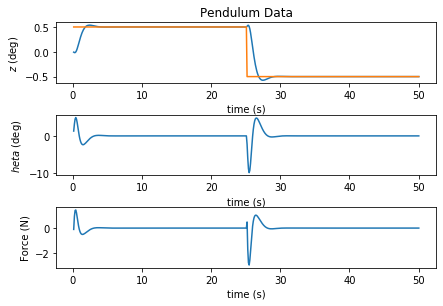

In [0]:
postProcessPlotPendulum(pendDataPlot)

# Examples - Design Study C: Satellite Control
The objective of this problem is to implement a state feedback controller using the
full state. Start with the simulation files developed in Homework C.10.

> (a) Modify the state feedback solution developed in Homework C.11 to add an
integrator with anti-windup.

> (b) Add a disturbance to the system and allow the system parameters to change
up to 20%.

> (c) Tune the integrator pole (and other gains if necessary) to get good tracking
performance.

In [0]:
%reset -f
# Design Problem C
# Start fresh, global namespace is clear: 
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

## C - (a)-(d) Design the Controller



In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_C_satellite/python/')
sys.path.append('control_book_public_solutions/_C_satellite/python/hw11')
import satelliteParam as P

In [0]:
# tuning parameters
wn_th = 0.6
wn_phi = 1.1    # rise time for angle
zeta_phi = 0.707  # damping ratio position
zeta_th = 0.707  # damping ratio angle

# State Space Equations
# xdot = A*x + B*u
# y = C*x
A = np.array([[0.0, 0.0,               1.0,      0.0],
               [0.0, 0.0,               0.0,      1.0],
               [-P.k/P.Js, P.k/P.Js, -P.b/P.Js, P.b/P.Js],
               [P.k/P.Jp, -P.k/P.Jp, P.b/P.Jp, -P.b/P.Jp]])

B = np.array([[0.0],
               [0.0],
               [1.0/P.Js],
               [0.0]])

C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])
Cr = np.array([[1.0, 0.0, 0.0, 0.0]])

n = A.shape[0]

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((n,1))),1)
Ai2 = np.concatenate((-Cr,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

# gain calculation
des_char_poly = np.convolve([1, 2*zeta_th*wn_th, wn_th**2],
                            [1, 2*zeta_phi*wn_phi, wn_phi**2])
des_poles = np.roots(des_char_poly)
# Add desired pole for integrator: 
des_poles = np.concatenate((des_poles,np.array([-1.])))

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(ctrb(Ai, Bi)) != n+1:
    print("The system is not controllable")
else:
    Kp = acker(Ai, Bi, des_poles)
    dpoles_old = des_poles[0:n]
    Kold = acker(A,B,dpoles_old)
    K = Kp[0,0:n]
    Ki = Kp[0,-1]
    kr = -1.0/(Cr @ np.linalg.inv(A - B @ Kold) @ B)

print('K: ', K)
print('Ki: ', Ki)
print('kr (for comparisions): ', kr)


K:  [[23.9895512 38.5740488 16.719     14.830112 ]]
Ki:  -14.519999999999987
kr (for comparisions):  [[14.52]]


## C - (e) Simulate the System
First set up a simple closed loop linear system to test out the control. 


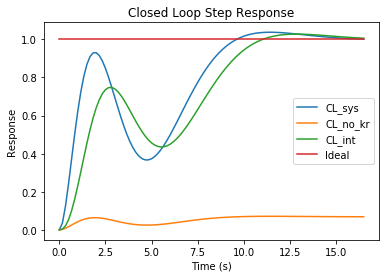

In [0]:
Acl = A - B@Kold
Bcl = B*kr
Ccl = Cr
Dcl = np.zeros((1,1))

Ael1 = np.concatenate((A - B @ K, -B * Ki),1)  # System dynamics
Ael3 = np.concatenate((-Cr, np.zeros((1, 1))), 1)  # Integrator State Dynamics
Ael = np.concatenate((Ael1, Ael3));
Bel = np.concatenate((B, np.ones((1, 1))))
Cel = np.concatenate((Cr, np.zeros((1, 1))), 1)
Del = np.zeros(1)

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,B,Ccl, Dcl)
sys_cli = ss(Ael,Bel,Cel,Del)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)
y3,t3 = step(sys_cli)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t3,y3,label='CL_int')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

K:  [[11.1458268  3.3741732 11.719     36.3246   ]]
kr:  [[14.52]]


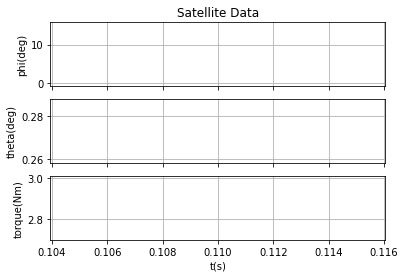

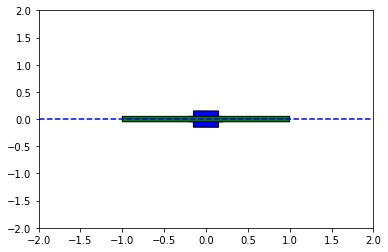

In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_C_satellite/python/')
sys.path.append('control_book_public_solutions/_C_satellite/python/hw11')
import satelliteParam as P
from hw3.satelliteDynamics import satelliteDynamics
from satelliteController import satelliteController
from hw2.signalGenerator import signalGenerator
from hw2.satelliteAnimation import satelliteAnimation
from hw2.dataPlotter import dataPlotter as satellitePlotData
P.k = 0.1

# instantiate satellite, controller, and reference classes
satellite = satelliteDynamics(0.1)
ctrl = satelliteController()
reference = signalGenerator(amplitude=15.0*np.pi/180.0, frequency=0.02)

# set disturbance input
disturbance = 0.50

# instantiate the simulation plots and animation
satDataPlot = satellitePlotData()
animation = satelliteAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot:  # updates control and dynamics at faster simulation rate
        tau = ctrl.update(ref_input, satellite.state)  # Calculate the control value
        sys_input = tau+disturbance  # input to plant is control input + disturbance (formatted as a list)
        satellite.update(sys_input)  # Propagate the dynamics with disturbance input
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(satellite.state)
    satDataPlot.update(t, ref_input, satellite.state, tau)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotSatellite(dataPlot_sat):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_sat.time_history, np.transpose([dataPlot_sat.phi_history, dataPlot_sat.phi_ref_history]))
  plt.title('Satellite Data' )
  plt.ylabel('$\phi$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_sat.time_history, np.transpose(dataPlot_sat.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_sat.time_history, dataPlot_sat.torque_history)
  plt.ylabel('Torque (Nm)')
  plt.xlabel('time (s)')

**Note**  If you get an error like this: *AttributeError: 'dataPlotter' object has no attribute 'phi_history'*  You are trying to run multiple Design Study problems in one session. Right now there is a known bug for this (probably too-similar naming convention and no namespaces).  Work around is to restart your instance, run the first couple of cells that import things, then come down here and run the Satellite simulation.  Then things should work out just fine. 

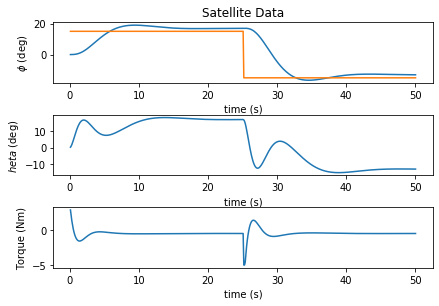

In [0]:
postProcessPlotSatellite(satDataPlot)